In [2]:
import pandas as pd
import numpy as np
import quandl
import os
items = ["WIKI/INTC", "WIKI/QCOM", "WIKI/NVDA", "WIKI/TXN", "WIKI/BRCM", "WIKI/GOOG"]
stock_data = "stock_data"

# if directory does not exist, create & download the data
if not os.path.exists(stock_data):
    os.makedirs(stock_data)
    for item in items:
        data = quandl.get(item)
        fileName = os.path.join(stock_data, item[5:]+".csv")
        with open(fileName, 'w+') as f:
            data.to_csv(f)

In [3]:
qcom = os.path.join(stock_data, "QCOM.csv")

Open           float64
High           float64
Low            float64
Close          float64
Volume         float64
Ex-Dividend    float64
Split Ratio    float64
Adj. Open      float64
Adj. High      float64
Adj. Low       float64
Adj. Close     float64
Adj. Volume    float64
dtype: object
            Adj. Open  Adj. High  Adj. Low  Adj. Close  Adj. Volume
Date                                                               
1991-12-16   0.399293   0.452929  0.399293    0.429091  143667200.0
1991-12-17   0.441010   0.441010  0.417172    0.423131   16176000.0
            Adj. Open  Adj. High  Adj. Low  Adj. Close  Adj. Volume
Date                                                               
2018-01-03      65.22      66.06     64.69       65.94    6721391.0
2018-01-04      66.18      66.53     65.91       66.03    5035323.0
            Adj. Open  Adj. High   Adj. Low  Adj. Close  Adj. Volume
Date                                                                
2006-01-03  33.696017  34.55

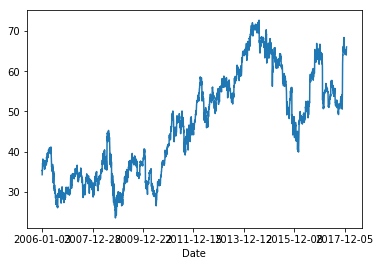

In [34]:
import matplotlib.pyplot as plt
qcom_data = pd.read_csv(qcom, index_col= [0], header=0, parse_dates=[1])
qcom_data['Open'] = qcom_data.Open.astype(float)
print(qcom_data.dtypes)
#qcom_data = qcom_data.drop(['Ex-Dividend', 'Split Ratio', 'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Volume'], axis=1)
qcom_data = qcom_data.drop(['Ex-Dividend', 'Split Ratio', 'Open', 'High', 'Close', 'Low', 'Volume'], axis=1)

print(qcom_data[:2])
print(qcom_data[-2:])

qcom_data = qcom_data.loc['2006-01-01':]
print(qcom_data[:2])
print(qcom_data.dtypes)
plt.figure()
qcom_data['Adj. Close'].plot()
plt.show()

Adj. Open      float64
Adj. High      float64
Adj. Low       float64
Adj. Close     float64
Adj. Volume    float64
dtype: object


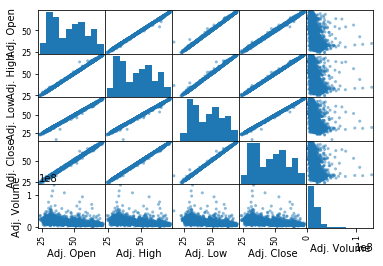

In [11]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
print(qcom_data.dtypes)
#qcom_data.plot(kind='density', subplots=True, layout=(3,3), sharex=False)
#plt.show()
scatter_matrix(qcom_data)
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

stockData = qcom_data
print(stockData.dtypes)
X = stockData.drop(['Adj. Close'], axis=1)
y = stockData[['Adj. Close']]#.astype(np.int64)
scalerX = MinMaxScaler(feature_range=(0, 1))
scalerY = MinMaxScaler(feature_range=(0, 1))
X_scaled = scalerX.fit_transform(X[X.columns])
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
y_scaled = scalerY.fit_transform(y[y.columns])
y_scaled = pd.DataFrame(y_scaled, columns=y.columns)
print("Inputs ares : ")
print(X_scaled.dtypes)
print(y_scaled.dtypes)

Open          float64
High          float64
Low           float64
Close         float64
Volume        float64
Adj. Close    float64
dtype: object
Inputs ares : 
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object
Adj. Close    float64
dtype: object


In [130]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math

def score(predicted, true_label):
    return math.sqrt(mean_squared_error(true_label, predicted))

#baseline model
def run_baseline(inputs, day_label):
    # predict day's label for next day
    return day_label

In [8]:
from sklearn.model_selection import TimeSeriesSplit
tsSplit = TimeSeriesSplit(n_splits=2)
scores = []
for train_index, test_index in tsSplit.split(X_scaled):
    X_train, X_test = X_scaled[0:len(train_index)], X_scaled[1+len(train_index):]
    y_train, y_test = y_scaled[0:len(train_index)], y_scaled[1+len(train_index):]
    predictedScaled = run_baseline(X_test[:-1], y_test[:-1])
    predicted = scalerY.inverse_transform(predictedScaled[predictedScaled.columns])
    predicted = pd.DataFrame(predicted, columns=predictedScaled.columns)
    trueValueScaled = y_test[1:]
    trueValue = scalerY.inverse_transform(trueValueScaled[trueValueScaled.columns])
    trueValue = pd.DataFrame(trueValue, columns=trueValueScaled.columns)
    scores.append(score(predicted, trueValue))
print(scores)

[0.8599890819549174, 0.9627239818315342]


In [147]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
from sklearn.model_selection import TimeSeriesSplit

# model = Sequential()
# print(qcom_data.iloc[:4]['Adj. Close'])
# print(qcom_data.iloc[:4]['Adj. Close'].shift(-1))
# temp = pd.DataFrame()
# temp['c1'] = qcom_data.iloc[:]['Adj. Close']
# temp['c2'] = qcom_data.iloc[:]['Adj. Close'].shift(-1)

# temp = temp.reset_index().drop(['Date'], axis=1)
# print(temp[:4])
# print(temp.dtypes)
def prepareData(stock_data, n_days):
    df = pd.DataFrame()
    for i in range(n_days):
        closeCol = 'c' + str(i);
        volCol = 'v' + str(i);
        df[closeCol] = stock_data.iloc[:]['Adj. Close'].shift(-i)
        df[volCol] = stock_data.iloc[:]['Adj. Volume'].shift(-i)
    df['y'] = stock_data.iloc[:]['Adj. Close'].shift(-2)
    df = df.reset_index().drop(['Date'], axis=1)
    df = df.dropna()
    print(df.shape)
    return df

def baseline_model(df, n_days):
    # predict close as of last known
    closeCol = 'c' + (str(n_days-1))
    result = df.drop(['y'], axis=1)
    result['y'] = df[:][closeCol]
    return result
    
def model_validation(df, n_days):
    tsSplit = TimeSeriesSplit(n_splits=2)
    baseline_scores = []
    for train_index, test_index in tsSplit.split(df):
        scaler_train = MinMaxScaler(feature_range=(0, 1))
        scaler_test = MinMaxScaler(feature_range=(0, 1))
        train, test = df[0:len(train_index)], df[1+len(train_index):]
        train_scaled = scaler_train.fit_transform(df[df.columns])
        train_scaled = pd.DataFrame(train_scaled, columns=df.columns)
        test_scaled = scaler_test.fit_transform(df[df.columns])
        test_scaled = pd.DataFrame(test_scaled, columns=df.columns)

        actual = test_scaled
        predicted = baseline_model(test_scaled, n_days)
        y_hat = scaler_test.inverse_transform(predicted)
        y_hat = pd.DataFrame(y_hat, columns=predicted.columns)
        y = scaler_test.inverse_transform(actual)
        y = pd.DataFrame(y, columns=actual.columns)
        baseline_scores.append(score(y_hat['y'], y['y']))
    print(baseline_scores)

history = 20
d = prepareData(qcom_data, history)
model_validation(d, history)


(3002, 41)
[3.1007590740761217, 3.1007590740761217]
